In [152]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm.notebook import tqdm
import os
import numpy as np
from torchvision import datasets
from torchvision import transforms as T
from torchvision.io import read_image
import torchvision.models as models
from torch.optim import Adam, SGD
import torch.nn.functional as F
import random

%matplotlib inline

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [154]:
device

device(type='cpu')

In [155]:
train_path = os.path.join(os.getcwd(), "data/fingers/train")

In [156]:
test_path = os.path.join(os.getcwd(), "data/fingers/test")

#### Reading data

In [157]:
class HandDataset(Dataset):
    def __init__(self, train_p, transform=None, one_hot=False):
        self._train_p = train_p
        self._one_hot = one_hot
        self._train_x, self._train_y = self.__get_tensors()
    
    def __get_tensors(self):
        train_files = [os.path.join(os.getcwd(), self._train_p, d) for d in os.listdir(self._train_p)]
        
        if self._one_hot:  
            train_y = F.one_hot(torch.Tensor([int(f[-6]) for f in train_files]).long(), 6)
        else:
            train_y = torch.Tensor([int(f[-6]) for f in train_files]).long()
        train_x = torch.stack(tuple(read_image(f) for f in train_files))
        
        return train_x, train_y
    
    def __len__(self):
        return len(self._train_x)
    
    def __getitem__(self, idx):
        if transform:
            return torch.squeeze(transform(self._train_x[idx])), self._train_y[idx]
        return self._train_x, self._train_y
    
  

In [158]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [159]:
transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    T.Normalize(mean=MEAN, std=STD)
]
)

In [160]:
train_ds = HandDataset(train_path, transform, False)

In [161]:
test_ds = HandDataset(test_path, transform, False)

#### Visualization

In [162]:
r_images = [random.randint(1, 10000) for _ in range(9)]

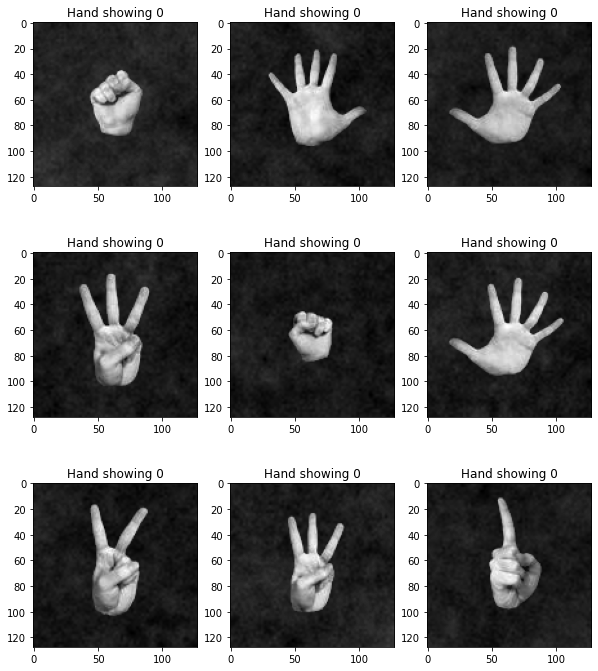

In [163]:
fig, axes = plt.subplots(3, 3, figsize=(10,12))
c = 0
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(train_ds[r_images[c]][0][1], cmap="gray")
        axes[i, j].set_title("Hand showing {}".format(torch.argmax(train_ds[r_images[c]][1])))
        c += 1

In [164]:
dense_mod = models.densenet121(pretrained=True)

In [165]:
# def get_model(name="densenet121", 
#               layer="classifier", 
#               device = "cpu",
#               layer_num=0, **kwargs):
    
#     if name == "densenet121":
#         model = models.densenet121(pretrained=True).to(device)
#     elif name == "alexnet":
#         model = models.alexnet(pretrained=True).to(device)
#     elif name == "resnet":
#         model = models.resnet101(pretrained=True).to(device)
#     elif name == "vgg":
#         model = models.vgg11(pretrained=True).to(device)
#     else:
#         raise Exception("model not found")
        
#     if layer == "classifier":
#         model.classifier[layer_num](kwargs)
    
#     elif layer == "features":
#         model.features[layer_num](kwargs)
    
    
#     return model

In [166]:
dense_mod.classifier.out_features = 6

In [167]:
dense_mod.classifier

Linear(in_features=1024, out_features=6, bias=True)

In [168]:
train_batch = 64

In [169]:
test_batch = 8

In [170]:
train_loader = DataLoader(train_ds, train_batch, shuffle=True)

In [171]:
test_loader = DataLoader(test_ds, test_batch, shuffle=True)

In [172]:
num_epoch = 20

In [173]:
opt = Adam(dense_mod.parameters(), lr=0.001)

In [175]:
for ep in tqdm(range(num_epoch)):
    train_losses = []
    for im, label in tqdm(iter(train_loader)):
        im = im.to(device)
        label = label.to(device)
        
        opt.zero_grad()
        outp = dense_mod(im)
        loss = F.cross_entropy(outp, label)
        loss.backward()
        
        opt.step()
        
        train_losses.append(loss.item())
    print(np.mean(train_losses))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

KeyboardInterrupt: 